# Multi-Factor Model

In [1]:
from datetime import datetime
import statsmodels.formula.api as sm
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd

In [2]:
#returns data
wrds_return = pd.read_excel("wrds_data.xlsx", sheet_name='returns')
wrds_return = pd.DataFrame(wrds_return[wrds_return.columns[:-5]])
wrds_return['date'] = wrds_return['Date'].apply(lambda x: datetime.strptime(x, "%Y-%m"))
wrds_return.set_index('date', inplace=True)
wrds_return.drop(columns=['Date'], inplace=True)
wrds_return['market_premium'] = wrds_return['S&P RETURN'] - wrds_return['RISK-FREE RATE']
wrds_return.head(4)


/opt/anaconda3/lib/python3.8/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


,MKT COMPOSITE RETURN,S&P RETURN,FAMA-FRENCH MARKET FACTOR,RISK-FREE RATE,FAMA-FRENCH SIZE FACTOR (SMB),FAMA-FRENCH VALUE FACTOR (HML),MOMENTUM FACTOR,BIOGEN INC,JOHNSON & JOHNSON,LILLY (ELI) & CO,...,CONAGRA BRANDS INC,COLGATE-PALMOLIVE CO,CAMPBELL SOUP CO,KELLOGG CO,KRAFT HEINZ CO,COCA-COLA CO,PROCTER & GAMBLE CO,TYSON FOODS INC -CL A,WALMART INC,market_premium
date,,,,,,,,,,,,,,,,,,,,,
1963-01-01,NaN,0.0491,0.0493,0.0025,0.0307,0.0222,-0.0210,NaN,0.1024,0.0915,...,NaN,0.0724,0.0935,0.1511,NaN,0.0587,0.0337,NaN,NaN,0.0466
1963-02-01,NaN,-0.0289,-0.0238,0.0023,0.0050,0.0217,0.0252,NaN,0.0196,0.0365,...,NaN,0.0000,-0.1033,-0.0602,NaN,-0.0028,-0.0307,NaN,NaN,-0.0312
1963-03-01,NaN,0.0355,0.0308,0.0023,-0.0260,0.0207,0.0156,NaN,0.0033,-0.0145,...,NaN,0.0722,0.0119,0.0992,NaN,0.0464,0.0423,NaN,NaN,0.0332
1963-04-01,NaN,0.0485,0.0451,0.0025,-0.0131,0.0099,-0.0008,NaN,0.0120,0.0501,...,NaN,0.0459,0.0031,-0.0526,NaN,-0.0107,0.0561,NaN,NaN,0.0460


In [3]:
#convert to quarterly frequency

wrdsq_return = wrds_return.resample('Q').mean()
wrdsq_return.reset_index(inplace=True)
wrdsq_return['quarter_date'] = pd.PeriodIndex(wrdsq_return.date, freq='Q')
wrdsq_return.head(3)

,date,MKT COMPOSITE RETURN,S&P RETURN,FAMA-FRENCH MARKET FACTOR,RISK-FREE RATE,FAMA-FRENCH SIZE FACTOR (SMB),FAMA-FRENCH VALUE FACTOR (HML),MOMENTUM FACTOR,BIOGEN INC,JOHNSON & JOHNSON,...,COLGATE-PALMOLIVE CO,CAMPBELL SOUP CO,KELLOGG CO,KRAFT HEINZ CO,COCA-COLA CO,PROCTER & GAMBLE CO,TYSON FOODS INC -CL A,WALMART INC,market_premium,quarter_date
0,1963-03-31,NaN,0.018567,0.018767,0.002367,0.003233,0.021533,0.006600,NaN,0.041767,...,0.048200,0.000700,0.063367,NaN,0.034100,0.015100,NaN,NaN,0.016200,1963Q1
1,1963-06-30,NaN,0.014200,0.014233,0.002400,-0.001600,0.014233,0.004867,NaN,0.020967,...,0.043067,0.000333,0.026900,NaN,0.003333,0.010067,NaN,NaN,0.011800,1963Q2
2,1963-09-30,NaN,0.011400,0.010367,0.002633,-0.006067,0.003500,0.007300,NaN,0.020300,...,0.011400,0.021067,0.021733,NaN,0.031200,0.016867,NaN,NaN,0.008767,1963Q3


In [4]:
#running stock-by-stock 3-factor Fama-French regressions
wrdsq_return.rename(columns={'RISK-FREE RATE':'rf', 'FAMA-FRENCH SIZE FACTOR (SMB)' : 'smb', 
                           'FAMA-FRENCH VALUE FACTOR (HML)': 'hml'}, inplace=True)


#renaming firms to gett rid of space
for firm in wrdsq_return.columns[7:-1]:
    firm_new = firm.replace(' ', '_').replace('-', '_')
    for pattern in ['&', '__', '(', ')']:
        firm_new = firm_new.replace(pattern, '')
    wrdsq_return.rename(columns={firm: firm_new}, inplace=True)
    
wrdsq_return.head(3)

,date,MKT COMPOSITE RETURN,S&P RETURN,FAMA-FRENCH MARKET FACTOR,rf,smb,hml,MOMENTUM_FACTOR,BIOGEN_INC,JOHNSONJOHNSON,...,COLGATE_PALMOLIVE_CO,CAMPBELL_SOUP_CO,KELLOGG_CO,KRAFT_HEINZ_CO,COCA_COLA_CO,PROCTERGAMBLE_CO,TYSON_FOODS_INC_CL_A,WALMART_INC,market_premium,quarter_date
0,1963-03-31,NaN,0.018567,0.018767,0.002367,0.003233,0.021533,0.006600,NaN,0.041767,...,0.048200,0.000700,0.063367,NaN,0.034100,0.015100,NaN,NaN,0.016200,1963Q1
1,1963-06-30,NaN,0.014200,0.014233,0.002400,-0.001600,0.014233,0.004867,NaN,0.020967,...,0.043067,0.000333,0.026900,NaN,0.003333,0.010067,NaN,NaN,0.011800,1963Q2
2,1963-09-30,NaN,0.011400,0.010367,0.002633,-0.006067,0.003500,0.007300,NaN,0.020300,...,0.011400,0.021067,0.021733,NaN,0.031200,0.016867,NaN,NaN,0.008767,1963Q3


In [5]:
#market portfolio

wrdsq_return['portfolio_ret'] = wrdsq_return[wrdsq_return.columns[8:-2]].mean(axis=1)
wrdsq_return = wrdsq_return[['portfolio_ret', 'quarter_date']]
wrdsq_return.head(3)

,portfolio_ret,quarter_date
0,0.030615,1963Q1
1,0.020812,1963Q2
2,0.014079,1963Q3


In [6]:
mev_historic = pd.read_csv('2021-table_1a_historic_domestic.csv')

#renaming column names to get rid of space and stuff
for column_name in mev_historic.columns:
    column_name_new = column_name.replace(' ', '_').replace('-', '_').lower()
    for pattern in ['&', '__', '(', ')']:
        column_name_new = column_name_new.replace(pattern, '')

    correction_dictionary = {'3': 'three', '5': 'five', '10': 'ten'}
    for pattern in ['3', '5', '10']:
        column_name_new = column_name_new.replace(pattern, correction_dictionary[pattern])
    mev_historic.rename(columns={column_name: column_name_new}, inplace=True)

mev_historic.rename(columns={'date': 'Date'}, inplace=True)    
quarter_number = {'Q1': '01', 'Q2': '04', 'Q3': '07', 'Q4': '10'}
mev_historic['date_str'] = mev_historic['Date'].apply(lambda x: x.split(' ')[0] + '-' + quarter_number[x.split(' ')[1]])
mev_historic['date'] = pd.to_datetime(mev_historic.date_str)
mev_historic['quarter_date'] = pd.PeriodIndex(mev_historic.date, freq='Q')
mev_historic.drop(columns=['date', 'date_str', 'Date', 'scenario_name'], inplace=True)
mev_historic.head(2)

,real_gdp_growth,nominal_gdp_growth,real_disposable_income_growth,nominal_disposable_income_growth,unemployment_rate,cpi_inflation_rate,three_month_treasury_rate,five_year_treasury_yield,ten_year_treasury_yield,bbb_corporate_yield,mortgage_rate,prime_rate,dow_jones_total_stock_market_index_level,house_price_index_level,commercial_real_estate_price_index_level,market_volatility_index_level,quarter_date
0,9.3,14.0,4.9,9.6,7.7,4.7,4.9,7.4,7.6,NaN,8.9,6.8,NaN,23.3,50.9,NaN,1976Q1
1,3.0,7.2,2.3,5.8,7.6,3.6,5.2,7.4,7.6,NaN,8.8,6.9,NaN,23.5,51.8,NaN,1976Q2


In [7]:
merged_wrds_mev = wrdsq_return.merge(mev_historic, on='quarter_date')
merged_wrds_mev.head(2)

,portfolio_ret,quarter_date,real_gdp_growth,nominal_gdp_growth,real_disposable_income_growth,nominal_disposable_income_growth,unemployment_rate,cpi_inflation_rate,three_month_treasury_rate,five_year_treasury_yield,ten_year_treasury_yield,bbb_corporate_yield,mortgage_rate,prime_rate,dow_jones_total_stock_market_index_level,house_price_index_level,commercial_real_estate_price_index_level,market_volatility_index_level
0,0.032416,1976Q1,9.3,14.0,4.9,9.6,7.7,4.7,4.9,7.4,7.6,NaN,8.9,6.8,NaN,23.3,50.9,NaN
1,0.005871,1976Q2,3.0,7.2,2.3,5.8,7.6,3.6,5.2,7.4,7.6,NaN,8.8,6.9,NaN,23.5,51.8,NaN


In [8]:
firms = merged_wrds_mev.columns[2:]
query = ' + '.join(firms)
query

'real_gdp_growth + nominal_gdp_growth + real_disposable_income_growth + nominal_disposable_income_growth + unemployment_rate + cpi_inflation_rate + three_month_treasury_rate + five_year_treasury_yield + ten_year_treasury_yield + bbb_corporate_yield + mortgage_rate + prime_rate + dow_jones_total_stock_market_index_level + house_price_index_level + commercial_real_estate_price_index_level + market_volatility_index_level'

In [9]:
result = sm.ols(formula="portfolio_ret ~ " + query, 
                data=merged_wrds_mev).fit(cov_type='HAC', cov_kwds={'maxlags':4})
result.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          portfolio_ret   R-squared:                       0.314
Model:                            OLS   Adj. R-squared:                  0.211
Method:                 Least Squares   F-statistic:                     16.07
Date:                Wed, 09 Nov 2022   Prob (F-statistic):           1.33e-21
Time:                        17:41:11   Log-Likelihood:                 291.13
No. Observations:                 124   AIC:                            -548.3
Df Residuals:                     107   BIC:                            -500.3
Df Model:                          16                                         
Covariance Type:                  HAC                                         
============================================================================================================
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                   -0.0351      0.041     -0.852      0.394      -0.116       0.046
real_gdp_growth                              0.0031      0.006      0.534      0.594      -0.008       0.014
nominal_gdp_growth                          -0.0036      0.005     -0.669      0.504      -0.014       0.007
real_disposable_income_growth                0.0051      0.006      0.836      0.403      -0.007       0.017
nominal_disposable_income_growth            -0.0057      0.006     -0.948      0.343      -0.018       0.006
unemployment_rate                            0.0055      0.002      3.595      0.000       0.003       0.009
cpi_inflation_rate                           0.0035      0.005      0.698      0.485      -0.006       0.013
three_month_treasury_rate                    0.0003      0.014      0.022      0.983      -0.028       0.028
five_year_treasury_yield                    -0.0108      0.016     -0.654      0.513      -0.043       0.022
ten_year_treasury_yield                      0.0029      0.017      0.176      0.860      -0.030       0.035
bbb_corporate_yield                          0.0078      0.006      1.258      0.208      -0.004       0.020
mortgage_rate                               -0.0024      0.018     -0.138      0.891      -0.037       0.032
prime_rate                                   0.0090      0.012      0.779      0.436      -0.014       0.032
dow_jones_total_stock_market_index_level  3.309e-06   7.05e-07      4.690      0.000    1.93e-06    4.69e-06
house_price_index_level                      0.0003      0.000      1.936      0.053   -3.65e-06       0.001
commercial_real_estate_price_index_level    -0.0005      0.000     -3.026      0.002      -0.001      -0.000
market_volatility_index_level               -0.0011      0.000     -5.803      0.000      -0.001      -0.001
==============================================================================
Omnibus:                        7.299   Durbin-Watson:                   2.446
Prob(Omnibus):                  0.026   Jarque-Bera (JB):               11.323
Skew:                           0.217   Prob(JB):                      0.00348
Kurtosis:                       4.415   Cond. No.                     4.15e+05
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 4 lags and without small sample correction
[2] The condition number is large, 4.15e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

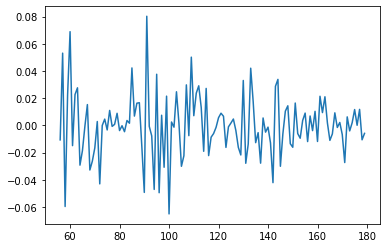

In [10]:
plt.plot(result.resid)
plt.savefig('multifactor_model.png')
plt.show()

In [11]:
betas = result.params

In [12]:
mevs = ['Real GDP growth', 'Nominal GDP growth',
       'Real disposable income growth', 'Nominal disposable income growth',
       'Unemployment rate', 'CPI inflation rate', '3-month Treasury rate',
       '5-year Treasury yield', '10-year Treasury yield',
       'BBB corporate yield', 'Mortgage rate', 'Prime rate',
       'Dow Jones Total Stock Market Index (Level)',
       'House Price Index (Level)',
       'Commercial Real Estate Price Index (Level)',
       'Market Volatility Index (Level)']

In [13]:
severe = pd.read_csv('2021-table_3a_supervisory_severely_adverse_domestic.csv')
severe = severe[mevs]


In [14]:
time0 = np.array(severe.iloc[0]) 
coeffs = np.array(betas[1:])
time1 = np.array(severe.iloc[3]) 

In [24]:
results_lst = []
lst = []
for n in range(4):
    print(n, np.dot(np.array(severe.iloc[n]), coeffs) + betas[0])
    lst.append(np.dot(np.array(severe.iloc[n]), coeffs) + betas[0])
    
results_lst.append(lst)

0 -0.016775175589195057
1 -0.004350591965465583
2 0.00048441341397836846
3 0.010233623676026926


In [25]:
baseline = pd.read_csv('2021-table_2a_supervisory_baseline_domestic.csv')
baseline = baseline[mevs]


In [26]:
lst = []
for n in range(4):
    print(n, np.dot(np.array(baseline.iloc[3]), coeffs) + betas[0])
    lst.append(np.dot(np.array(baseline.iloc[3]), coeffs) + betas[0])

results_lst.append(lst)

0 0.05493593671916108
1 0.05493593671916108
2 0.05493593671916108
3 0.05493593671916108


In [30]:
pd.DataFrame(np.array(results_lst).transpose(), columns=['Severe', 'Baseline'])

,Severe,Baseline
0,-0.016775,0.054936
1,-0.004351,0.054936
2,0.000484,0.054936
3,0.010234,0.054936


**Comments:** The Adjusted R-squared for Multi-factor model is around 0.319. As one might expect, the time0/time1 projection for severe scenario is less than the projections for the baseline scenario (time0/time1). 